# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

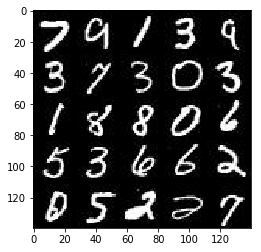

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

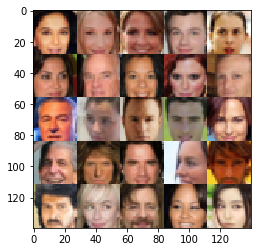

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], "input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], "input_z")
    learning_rate = tf.placeholder(tf.float32, None, "learning_rate")

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [14]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    
    def conv(inputs, filters, batch_norm=True):
        outputs = tf.layers.conv2d(inputs, filters, 5, 2, 'same')
        if batch_norm:
            outputs = tf.layers.batch_normalization(outputs, training=True)
        return leaky_relu(outputs)
        
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # input 28*28*3
        x1 = conv(images, 64, batch_norm=False) # 14*14*64
        x2 = conv(x1, 128) # 7*7*128
        x3 = conv(x2, 256) # 4*4*256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        # 7*7*512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 1, 'SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        # 7*7*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, 'SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        # 14*14*128
    
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 2, 'SAME')
        out = tf.tanh(logits)
        # 28*28*out_channel_dim
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [17]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * alpha))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        t_vars = tf.trainable_variables()
        
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]

        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 0.5023... Generator Loss: 10.1671
Epoch 1/2... Batch 20... Discriminator Loss: 0.7331... Generator Loss: 2.8746
Epoch 1/2... Batch 30... Discriminator Loss: 1.4220... Generator Loss: 0.5547
Epoch 1/2... Batch 40... Discriminator Loss: 0.7115... Generator Loss: 2.0606
Epoch 1/2... Batch 50... Discriminator Loss: 1.7921... Generator Loss: 1.1291
Epoch 1/2... Batch 60... Discriminator Loss: 0.9696... Generator Loss: 1.6962
Epoch 1/2... Batch 70... Discriminator Loss: 1.4085... Generator Loss: 3.3560
Epoch 1/2... Batch 80... Discriminator Loss: 2.1041... Generator Loss: 0.2545
Epoch 1/2... Batch 90... Discriminator Loss: 1.3636... Generator Loss: 0.7639
Epoch 1/2... Batch 100... Discriminator Loss: 1.3319... Generator Loss: 0.8238


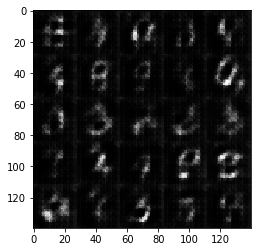

Epoch 1/2... Batch 110... Discriminator Loss: 1.5062... Generator Loss: 1.8291
Epoch 1/2... Batch 120... Discriminator Loss: 1.3286... Generator Loss: 2.2886
Epoch 1/2... Batch 130... Discriminator Loss: 1.2690... Generator Loss: 1.7916
Epoch 1/2... Batch 140... Discriminator Loss: 1.1989... Generator Loss: 1.0170
Epoch 1/2... Batch 150... Discriminator Loss: 1.7810... Generator Loss: 0.3555
Epoch 1/2... Batch 160... Discriminator Loss: 1.3277... Generator Loss: 1.9207
Epoch 1/2... Batch 170... Discriminator Loss: 1.1771... Generator Loss: 1.0994
Epoch 1/2... Batch 180... Discriminator Loss: 1.2264... Generator Loss: 0.9521
Epoch 1/2... Batch 190... Discriminator Loss: 1.1879... Generator Loss: 0.9130
Epoch 1/2... Batch 200... Discriminator Loss: 1.1921... Generator Loss: 0.9770


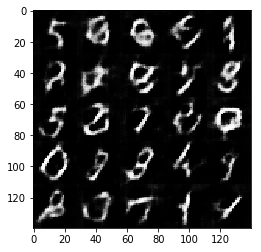

Epoch 1/2... Batch 210... Discriminator Loss: 1.3045... Generator Loss: 1.5732
Epoch 1/2... Batch 220... Discriminator Loss: 1.1723... Generator Loss: 1.2785
Epoch 1/2... Batch 230... Discriminator Loss: 1.5844... Generator Loss: 0.4284
Epoch 1/2... Batch 240... Discriminator Loss: 1.2048... Generator Loss: 0.8117
Epoch 1/2... Batch 250... Discriminator Loss: 1.2200... Generator Loss: 1.1132
Epoch 1/2... Batch 260... Discriminator Loss: 1.2036... Generator Loss: 1.0324
Epoch 1/2... Batch 270... Discriminator Loss: 1.3243... Generator Loss: 0.6558
Epoch 1/2... Batch 280... Discriminator Loss: 1.2193... Generator Loss: 1.0246
Epoch 1/2... Batch 290... Discriminator Loss: 1.4078... Generator Loss: 0.5536
Epoch 1/2... Batch 300... Discriminator Loss: 1.1370... Generator Loss: 0.8943


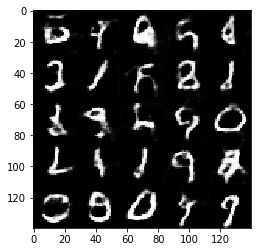

Epoch 1/2... Batch 310... Discriminator Loss: 1.5961... Generator Loss: 0.4119
Epoch 1/2... Batch 320... Discriminator Loss: 1.1567... Generator Loss: 1.0943
Epoch 1/2... Batch 330... Discriminator Loss: 1.2707... Generator Loss: 1.2338
Epoch 1/2... Batch 340... Discriminator Loss: 1.3841... Generator Loss: 0.5535
Epoch 1/2... Batch 350... Discriminator Loss: 1.3581... Generator Loss: 1.5332
Epoch 1/2... Batch 360... Discriminator Loss: 1.2775... Generator Loss: 1.0803
Epoch 1/2... Batch 370... Discriminator Loss: 1.6444... Generator Loss: 0.3900
Epoch 1/2... Batch 380... Discriminator Loss: 1.1722... Generator Loss: 1.2828
Epoch 1/2... Batch 390... Discriminator Loss: 1.5357... Generator Loss: 0.4443
Epoch 1/2... Batch 400... Discriminator Loss: 1.2018... Generator Loss: 0.7616


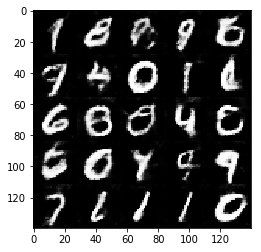

Epoch 1/2... Batch 410... Discriminator Loss: 1.1899... Generator Loss: 0.9666
Epoch 1/2... Batch 420... Discriminator Loss: 1.1645... Generator Loss: 1.0815
Epoch 1/2... Batch 430... Discriminator Loss: 1.1591... Generator Loss: 0.8335
Epoch 1/2... Batch 440... Discriminator Loss: 1.2725... Generator Loss: 1.3386
Epoch 1/2... Batch 450... Discriminator Loss: 1.2971... Generator Loss: 0.6593
Epoch 1/2... Batch 460... Discriminator Loss: 1.2719... Generator Loss: 0.6270
Epoch 2/2... Batch 10... Discriminator Loss: 1.2456... Generator Loss: 0.9324
Epoch 2/2... Batch 20... Discriminator Loss: 1.2295... Generator Loss: 0.7748
Epoch 2/2... Batch 30... Discriminator Loss: 1.2060... Generator Loss: 0.8762
Epoch 2/2... Batch 40... Discriminator Loss: 1.2028... Generator Loss: 1.1106
Epoch 2/2... Batch 50... Discriminator Loss: 1.1809... Generator Loss: 0.8044
Epoch 2/2... Batch 60... Discriminator Loss: 1.2829... Generator Loss: 1.3515
Epoch 2/2... Batch 70... Discriminator Loss: 1.1259... Gen

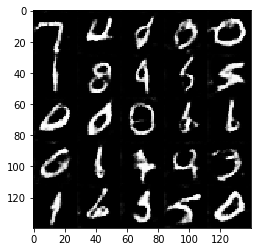

Epoch 2/2... Batch 110... Discriminator Loss: 1.3258... Generator Loss: 1.2924
Epoch 2/2... Batch 120... Discriminator Loss: 1.1654... Generator Loss: 0.9128
Epoch 2/2... Batch 130... Discriminator Loss: 1.4688... Generator Loss: 0.5322
Epoch 2/2... Batch 140... Discriminator Loss: 1.2305... Generator Loss: 0.8590
Epoch 2/2... Batch 150... Discriminator Loss: 1.4073... Generator Loss: 0.5201
Epoch 2/2... Batch 160... Discriminator Loss: 1.3877... Generator Loss: 1.6854
Epoch 2/2... Batch 170... Discriminator Loss: 1.2994... Generator Loss: 0.6121
Epoch 2/2... Batch 180... Discriminator Loss: 1.3761... Generator Loss: 0.5295
Epoch 2/2... Batch 190... Discriminator Loss: 1.5615... Generator Loss: 0.4135
Epoch 2/2... Batch 200... Discriminator Loss: 1.1619... Generator Loss: 0.8113


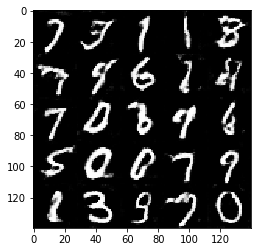

Epoch 2/2... Batch 210... Discriminator Loss: 1.1363... Generator Loss: 1.0318
Epoch 2/2... Batch 220... Discriminator Loss: 1.2543... Generator Loss: 1.6990
Epoch 2/2... Batch 230... Discriminator Loss: 1.2923... Generator Loss: 0.7714
Epoch 2/2... Batch 240... Discriminator Loss: 1.5269... Generator Loss: 1.8351
Epoch 2/2... Batch 250... Discriminator Loss: 1.2152... Generator Loss: 1.1371
Epoch 2/2... Batch 260... Discriminator Loss: 1.7497... Generator Loss: 2.1506
Epoch 2/2... Batch 270... Discriminator Loss: 1.1943... Generator Loss: 0.8152
Epoch 2/2... Batch 280... Discriminator Loss: 1.2333... Generator Loss: 1.2407
Epoch 2/2... Batch 290... Discriminator Loss: 1.3056... Generator Loss: 1.1477
Epoch 2/2... Batch 300... Discriminator Loss: 1.4746... Generator Loss: 0.4845


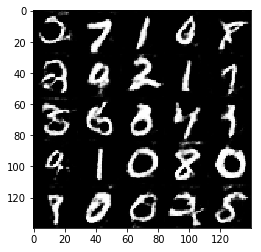

Epoch 2/2... Batch 310... Discriminator Loss: 1.2023... Generator Loss: 1.1614
Epoch 2/2... Batch 320... Discriminator Loss: 1.5587... Generator Loss: 0.4050
Epoch 2/2... Batch 330... Discriminator Loss: 1.3034... Generator Loss: 0.6178
Epoch 2/2... Batch 340... Discriminator Loss: 1.1116... Generator Loss: 0.9359
Epoch 2/2... Batch 350... Discriminator Loss: 1.3498... Generator Loss: 1.5920
Epoch 2/2... Batch 360... Discriminator Loss: 1.4162... Generator Loss: 0.5167
Epoch 2/2... Batch 370... Discriminator Loss: 1.1702... Generator Loss: 1.2913
Epoch 2/2... Batch 380... Discriminator Loss: 1.0914... Generator Loss: 1.0081
Epoch 2/2... Batch 390... Discriminator Loss: 1.0676... Generator Loss: 1.1180
Epoch 2/2... Batch 400... Discriminator Loss: 1.1455... Generator Loss: 0.8965


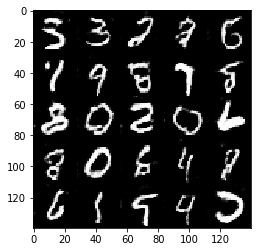

Epoch 2/2... Batch 410... Discriminator Loss: 1.2998... Generator Loss: 1.6718
Epoch 2/2... Batch 420... Discriminator Loss: 1.3026... Generator Loss: 0.6136
Epoch 2/2... Batch 430... Discriminator Loss: 1.1128... Generator Loss: 1.1152
Epoch 2/2... Batch 440... Discriminator Loss: 1.2098... Generator Loss: 1.2661
Epoch 2/2... Batch 450... Discriminator Loss: 1.2246... Generator Loss: 1.6822
Epoch 2/2... Batch 460... Discriminator Loss: 1.5625... Generator Loss: 0.4671


In [22]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 1.8236... Generator Loss: 0.4151
Epoch 1/1... Batch 20... Discriminator Loss: 0.8843... Generator Loss: 1.1989
Epoch 1/1... Batch 30... Discriminator Loss: 0.9429... Generator Loss: 1.1499
Epoch 1/1... Batch 40... Discriminator Loss: 0.5765... Generator Loss: 2.1516
Epoch 1/1... Batch 50... Discriminator Loss: 0.7011... Generator Loss: 1.5499
Epoch 1/1... Batch 60... Discriminator Loss: 0.5164... Generator Loss: 4.0524
Epoch 1/1... Batch 70... Discriminator Loss: 0.7842... Generator Loss: 1.6202
Epoch 1/1... Batch 80... Discriminator Loss: 0.4507... Generator Loss: 2.8683
Epoch 1/1... Batch 90... Discriminator Loss: 0.5184... Generator Loss: 2.4632
Epoch 1/1... Batch 100... Discriminator Loss: 0.4922... Generator Loss: 2.3662


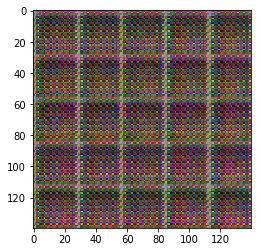

Epoch 1/1... Batch 110... Discriminator Loss: 1.1330... Generator Loss: 5.3818
Epoch 1/1... Batch 120... Discriminator Loss: 0.6224... Generator Loss: 2.1202
Epoch 1/1... Batch 130... Discriminator Loss: 0.4660... Generator Loss: 2.9098
Epoch 1/1... Batch 140... Discriminator Loss: 0.5721... Generator Loss: 1.8699
Epoch 1/1... Batch 150... Discriminator Loss: 0.4608... Generator Loss: 2.8259
Epoch 1/1... Batch 160... Discriminator Loss: 0.7344... Generator Loss: 1.2801
Epoch 1/1... Batch 170... Discriminator Loss: 0.5873... Generator Loss: 2.4148
Epoch 1/1... Batch 180... Discriminator Loss: 0.5162... Generator Loss: 2.6038
Epoch 1/1... Batch 190... Discriminator Loss: 0.8539... Generator Loss: 1.4887
Epoch 1/1... Batch 200... Discriminator Loss: 0.6922... Generator Loss: 1.5948


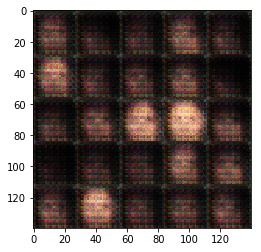

Epoch 1/1... Batch 210... Discriminator Loss: 0.8914... Generator Loss: 1.3890
Epoch 1/1... Batch 220... Discriminator Loss: 0.6816... Generator Loss: 1.7021
Epoch 1/1... Batch 230... Discriminator Loss: 0.9156... Generator Loss: 1.9814
Epoch 1/1... Batch 240... Discriminator Loss: 0.6860... Generator Loss: 1.8209
Epoch 1/1... Batch 250... Discriminator Loss: 0.7485... Generator Loss: 2.5880
Epoch 1/1... Batch 260... Discriminator Loss: 0.7131... Generator Loss: 1.9776
Epoch 1/1... Batch 270... Discriminator Loss: 0.6336... Generator Loss: 2.0046
Epoch 1/1... Batch 280... Discriminator Loss: 0.9490... Generator Loss: 3.0053
Epoch 1/1... Batch 290... Discriminator Loss: 0.7352... Generator Loss: 1.4627
Epoch 1/1... Batch 300... Discriminator Loss: 0.6917... Generator Loss: 1.8301


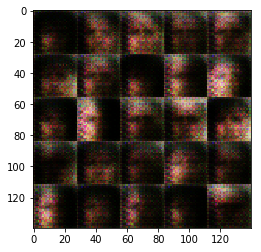

Epoch 1/1... Batch 310... Discriminator Loss: 1.3062... Generator Loss: 0.5915
Epoch 1/1... Batch 320... Discriminator Loss: 0.7876... Generator Loss: 2.1243
Epoch 1/1... Batch 330... Discriminator Loss: 0.9186... Generator Loss: 1.2098
Epoch 1/1... Batch 340... Discriminator Loss: 0.6813... Generator Loss: 1.9932
Epoch 1/1... Batch 350... Discriminator Loss: 0.8240... Generator Loss: 1.7830
Epoch 1/1... Batch 360... Discriminator Loss: 0.8137... Generator Loss: 1.4422
Epoch 1/1... Batch 370... Discriminator Loss: 0.8586... Generator Loss: 1.2161
Epoch 1/1... Batch 380... Discriminator Loss: 0.8126... Generator Loss: 1.4690
Epoch 1/1... Batch 390... Discriminator Loss: 1.0099... Generator Loss: 1.9719
Epoch 1/1... Batch 400... Discriminator Loss: 1.1254... Generator Loss: 1.5945


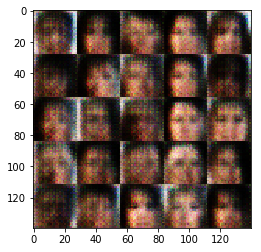

Epoch 1/1... Batch 410... Discriminator Loss: 0.9919... Generator Loss: 1.2699
Epoch 1/1... Batch 420... Discriminator Loss: 1.1094... Generator Loss: 2.3880
Epoch 1/1... Batch 430... Discriminator Loss: 1.0226... Generator Loss: 1.0347
Epoch 1/1... Batch 440... Discriminator Loss: 1.0432... Generator Loss: 1.7201
Epoch 1/1... Batch 450... Discriminator Loss: 0.8027... Generator Loss: 2.2196
Epoch 1/1... Batch 460... Discriminator Loss: 0.9369... Generator Loss: 2.3225
Epoch 1/1... Batch 470... Discriminator Loss: 0.8285... Generator Loss: 1.9485
Epoch 1/1... Batch 480... Discriminator Loss: 0.8544... Generator Loss: 1.4568
Epoch 1/1... Batch 490... Discriminator Loss: 0.8625... Generator Loss: 1.4166
Epoch 1/1... Batch 500... Discriminator Loss: 0.8875... Generator Loss: 1.3849


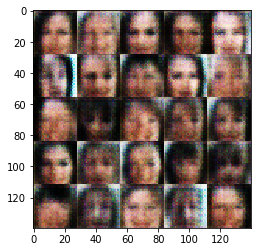

Epoch 1/1... Batch 510... Discriminator Loss: 1.0365... Generator Loss: 0.9484
Epoch 1/1... Batch 520... Discriminator Loss: 0.9659... Generator Loss: 1.1066
Epoch 1/1... Batch 530... Discriminator Loss: 0.9442... Generator Loss: 1.1818
Epoch 1/1... Batch 540... Discriminator Loss: 0.9235... Generator Loss: 1.2676
Epoch 1/1... Batch 550... Discriminator Loss: 1.2688... Generator Loss: 0.6144
Epoch 1/1... Batch 560... Discriminator Loss: 0.9778... Generator Loss: 1.3150
Epoch 1/1... Batch 570... Discriminator Loss: 0.9567... Generator Loss: 1.4069
Epoch 1/1... Batch 580... Discriminator Loss: 0.9454... Generator Loss: 1.2413
Epoch 1/1... Batch 590... Discriminator Loss: 0.9886... Generator Loss: 1.3998
Epoch 1/1... Batch 600... Discriminator Loss: 1.2866... Generator Loss: 0.8839


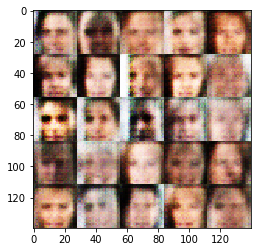

Epoch 1/1... Batch 610... Discriminator Loss: 1.1730... Generator Loss: 1.5709
Epoch 1/1... Batch 620... Discriminator Loss: 1.1417... Generator Loss: 0.8438
Epoch 1/1... Batch 630... Discriminator Loss: 1.1508... Generator Loss: 1.2058
Epoch 1/1... Batch 640... Discriminator Loss: 1.2297... Generator Loss: 0.7459
Epoch 1/1... Batch 650... Discriminator Loss: 1.1362... Generator Loss: 1.0644
Epoch 1/1... Batch 660... Discriminator Loss: 0.9790... Generator Loss: 1.4662
Epoch 1/1... Batch 670... Discriminator Loss: 1.0667... Generator Loss: 0.9595
Epoch 1/1... Batch 680... Discriminator Loss: 1.2148... Generator Loss: 1.4908
Epoch 1/1... Batch 690... Discriminator Loss: 1.1831... Generator Loss: 0.7800
Epoch 1/1... Batch 700... Discriminator Loss: 1.1624... Generator Loss: 1.0584


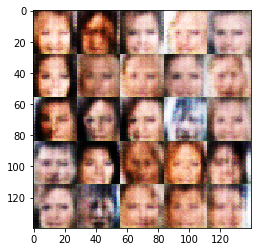

Epoch 1/1... Batch 710... Discriminator Loss: 1.1535... Generator Loss: 1.3768
Epoch 1/1... Batch 720... Discriminator Loss: 1.2399... Generator Loss: 0.6990
Epoch 1/1... Batch 730... Discriminator Loss: 0.9826... Generator Loss: 1.2530
Epoch 1/1... Batch 740... Discriminator Loss: 1.3965... Generator Loss: 1.8528
Epoch 1/1... Batch 750... Discriminator Loss: 0.8994... Generator Loss: 1.2794
Epoch 1/1... Batch 760... Discriminator Loss: 1.3019... Generator Loss: 0.7192
Epoch 1/1... Batch 770... Discriminator Loss: 1.0077... Generator Loss: 1.1151
Epoch 1/1... Batch 780... Discriminator Loss: 1.1487... Generator Loss: 0.9126
Epoch 1/1... Batch 790... Discriminator Loss: 1.1114... Generator Loss: 1.0136
Epoch 1/1... Batch 800... Discriminator Loss: 0.9605... Generator Loss: 1.3449


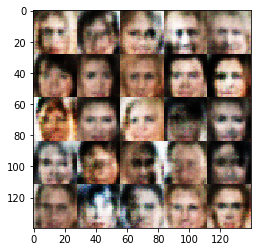

Epoch 1/1... Batch 810... Discriminator Loss: 1.2511... Generator Loss: 0.6702
Epoch 1/1... Batch 820... Discriminator Loss: 1.0960... Generator Loss: 1.0307
Epoch 1/1... Batch 830... Discriminator Loss: 1.0533... Generator Loss: 1.1679
Epoch 1/1... Batch 840... Discriminator Loss: 0.9293... Generator Loss: 1.5997
Epoch 1/1... Batch 850... Discriminator Loss: 1.2585... Generator Loss: 1.9971
Epoch 1/1... Batch 860... Discriminator Loss: 1.0533... Generator Loss: 1.0408
Epoch 1/1... Batch 870... Discriminator Loss: 1.1478... Generator Loss: 0.8496
Epoch 1/1... Batch 880... Discriminator Loss: 0.9898... Generator Loss: 1.0445
Epoch 1/1... Batch 890... Discriminator Loss: 0.9620... Generator Loss: 1.0733
Epoch 1/1... Batch 900... Discriminator Loss: 1.0888... Generator Loss: 1.1844


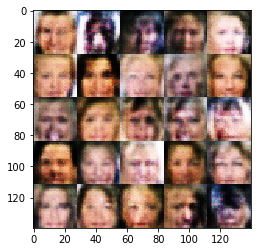

Epoch 1/1... Batch 910... Discriminator Loss: 0.9967... Generator Loss: 1.5018
Epoch 1/1... Batch 920... Discriminator Loss: 1.0503... Generator Loss: 1.2610
Epoch 1/1... Batch 930... Discriminator Loss: 1.2574... Generator Loss: 0.6901
Epoch 1/1... Batch 940... Discriminator Loss: 1.1126... Generator Loss: 1.2068
Epoch 1/1... Batch 950... Discriminator Loss: 1.1067... Generator Loss: 0.8364
Epoch 1/1... Batch 960... Discriminator Loss: 0.9593... Generator Loss: 1.2906
Epoch 1/1... Batch 970... Discriminator Loss: 1.1549... Generator Loss: 0.8852
Epoch 1/1... Batch 980... Discriminator Loss: 1.0898... Generator Loss: 1.1487
Epoch 1/1... Batch 990... Discriminator Loss: 0.8725... Generator Loss: 1.5555
Epoch 1/1... Batch 1000... Discriminator Loss: 1.2490... Generator Loss: 0.6078


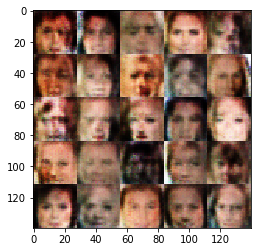

Epoch 1/1... Batch 1010... Discriminator Loss: 1.2357... Generator Loss: 1.0864
Epoch 1/1... Batch 1020... Discriminator Loss: 1.1200... Generator Loss: 1.0384
Epoch 1/1... Batch 1030... Discriminator Loss: 1.0880... Generator Loss: 0.9210
Epoch 1/1... Batch 1040... Discriminator Loss: 1.1972... Generator Loss: 0.7475
Epoch 1/1... Batch 1050... Discriminator Loss: 1.1834... Generator Loss: 0.9295
Epoch 1/1... Batch 1060... Discriminator Loss: 1.3004... Generator Loss: 0.6709
Epoch 1/1... Batch 1070... Discriminator Loss: 1.1259... Generator Loss: 0.9022
Epoch 1/1... Batch 1080... Discriminator Loss: 1.5175... Generator Loss: 0.4470
Epoch 1/1... Batch 1090... Discriminator Loss: 1.0140... Generator Loss: 1.1199
Epoch 1/1... Batch 1100... Discriminator Loss: 1.2778... Generator Loss: 0.7453


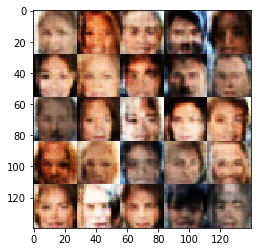

Epoch 1/1... Batch 1110... Discriminator Loss: 0.9830... Generator Loss: 1.2853
Epoch 1/1... Batch 1120... Discriminator Loss: 1.0858... Generator Loss: 0.8473
Epoch 1/1... Batch 1130... Discriminator Loss: 0.9487... Generator Loss: 1.1323
Epoch 1/1... Batch 1140... Discriminator Loss: 0.9809... Generator Loss: 1.0053
Epoch 1/1... Batch 1150... Discriminator Loss: 1.1323... Generator Loss: 0.8671
Epoch 1/1... Batch 1160... Discriminator Loss: 1.0091... Generator Loss: 1.0450
Epoch 1/1... Batch 1170... Discriminator Loss: 1.5416... Generator Loss: 0.4452
Epoch 1/1... Batch 1180... Discriminator Loss: 1.3798... Generator Loss: 0.5514
Epoch 1/1... Batch 1190... Discriminator Loss: 1.0347... Generator Loss: 1.2749
Epoch 1/1... Batch 1200... Discriminator Loss: 1.2267... Generator Loss: 0.9485


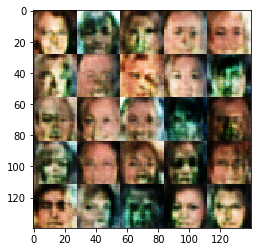

Epoch 1/1... Batch 1210... Discriminator Loss: 1.0509... Generator Loss: 1.0538
Epoch 1/1... Batch 1220... Discriminator Loss: 1.0773... Generator Loss: 1.1523
Epoch 1/1... Batch 1230... Discriminator Loss: 1.1189... Generator Loss: 0.9319
Epoch 1/1... Batch 1240... Discriminator Loss: 1.1188... Generator Loss: 1.2453
Epoch 1/1... Batch 1250... Discriminator Loss: 1.1002... Generator Loss: 1.2368
Epoch 1/1... Batch 1260... Discriminator Loss: 1.2165... Generator Loss: 0.7982
Epoch 1/1... Batch 1270... Discriminator Loss: 0.8987... Generator Loss: 1.3679
Epoch 1/1... Batch 1280... Discriminator Loss: 1.0369... Generator Loss: 1.0567
Epoch 1/1... Batch 1290... Discriminator Loss: 1.1413... Generator Loss: 1.3607
Epoch 1/1... Batch 1300... Discriminator Loss: 1.3107... Generator Loss: 0.6911


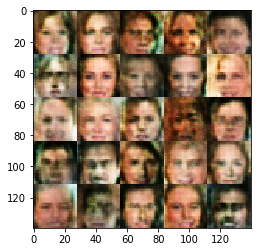

Epoch 1/1... Batch 1310... Discriminator Loss: 1.1344... Generator Loss: 0.8684
Epoch 1/1... Batch 1320... Discriminator Loss: 0.9574... Generator Loss: 1.3883
Epoch 1/1... Batch 1330... Discriminator Loss: 1.0906... Generator Loss: 1.1974
Epoch 1/1... Batch 1340... Discriminator Loss: 1.2101... Generator Loss: 0.8798
Epoch 1/1... Batch 1350... Discriminator Loss: 1.1580... Generator Loss: 0.9512
Epoch 1/1... Batch 1360... Discriminator Loss: 1.1314... Generator Loss: 0.8161
Epoch 1/1... Batch 1370... Discriminator Loss: 1.0670... Generator Loss: 1.1263
Epoch 1/1... Batch 1380... Discriminator Loss: 1.0108... Generator Loss: 1.2044
Epoch 1/1... Batch 1390... Discriminator Loss: 1.1591... Generator Loss: 0.9195
Epoch 1/1... Batch 1400... Discriminator Loss: 0.9682... Generator Loss: 1.0537


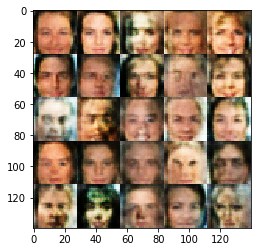

Epoch 1/1... Batch 1410... Discriminator Loss: 1.1889... Generator Loss: 0.8402
Epoch 1/1... Batch 1420... Discriminator Loss: 1.0190... Generator Loss: 1.0913
Epoch 1/1... Batch 1430... Discriminator Loss: 1.1992... Generator Loss: 1.2365
Epoch 1/1... Batch 1440... Discriminator Loss: 1.0256... Generator Loss: 1.2105
Epoch 1/1... Batch 1450... Discriminator Loss: 1.1924... Generator Loss: 0.7207
Epoch 1/1... Batch 1460... Discriminator Loss: 1.0838... Generator Loss: 1.0756
Epoch 1/1... Batch 1470... Discriminator Loss: 1.2390... Generator Loss: 0.7845
Epoch 1/1... Batch 1480... Discriminator Loss: 1.0655... Generator Loss: 1.1363
Epoch 1/1... Batch 1490... Discriminator Loss: 0.9189... Generator Loss: 1.7885
Epoch 1/1... Batch 1500... Discriminator Loss: 1.2903... Generator Loss: 0.6059


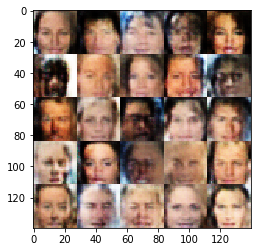

Epoch 1/1... Batch 1510... Discriminator Loss: 1.1131... Generator Loss: 1.0217
Epoch 1/1... Batch 1520... Discriminator Loss: 1.1617... Generator Loss: 0.8533
Epoch 1/1... Batch 1530... Discriminator Loss: 1.1908... Generator Loss: 0.9112
Epoch 1/1... Batch 1540... Discriminator Loss: 1.0493... Generator Loss: 1.0937
Epoch 1/1... Batch 1550... Discriminator Loss: 1.4271... Generator Loss: 0.5318
Epoch 1/1... Batch 1560... Discriminator Loss: 1.2189... Generator Loss: 0.7152
Epoch 1/1... Batch 1570... Discriminator Loss: 0.9473... Generator Loss: 1.5927
Epoch 1/1... Batch 1580... Discriminator Loss: 1.1378... Generator Loss: 1.1625
Epoch 1/1... Batch 1590... Discriminator Loss: 0.9757... Generator Loss: 1.1408
Epoch 1/1... Batch 1600... Discriminator Loss: 1.4252... Generator Loss: 0.6695


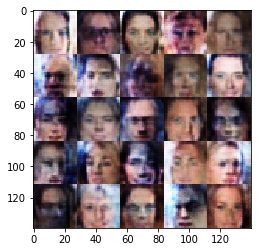

Epoch 1/1... Batch 1610... Discriminator Loss: 1.2253... Generator Loss: 0.9132
Epoch 1/1... Batch 1620... Discriminator Loss: 1.0670... Generator Loss: 0.9742
Epoch 1/1... Batch 1630... Discriminator Loss: 1.1879... Generator Loss: 0.7359
Epoch 1/1... Batch 1640... Discriminator Loss: 0.8743... Generator Loss: 1.5454
Epoch 1/1... Batch 1650... Discriminator Loss: 1.2755... Generator Loss: 0.9938
Epoch 1/1... Batch 1660... Discriminator Loss: 1.1568... Generator Loss: 0.7954
Epoch 1/1... Batch 1670... Discriminator Loss: 1.1638... Generator Loss: 0.9968
Epoch 1/1... Batch 1680... Discriminator Loss: 1.1343... Generator Loss: 1.4069
Epoch 1/1... Batch 1690... Discriminator Loss: 1.2027... Generator Loss: 1.0717
Epoch 1/1... Batch 1700... Discriminator Loss: 1.0915... Generator Loss: 1.0098


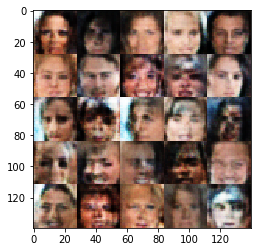

Epoch 1/1... Batch 1710... Discriminator Loss: 1.1598... Generator Loss: 0.8583
Epoch 1/1... Batch 1720... Discriminator Loss: 1.0200... Generator Loss: 1.0383
Epoch 1/1... Batch 1730... Discriminator Loss: 1.2099... Generator Loss: 1.4879
Epoch 1/1... Batch 1740... Discriminator Loss: 0.9514... Generator Loss: 1.4366
Epoch 1/1... Batch 1750... Discriminator Loss: 1.1760... Generator Loss: 0.8586
Epoch 1/1... Batch 1760... Discriminator Loss: 1.2419... Generator Loss: 0.7236
Epoch 1/1... Batch 1770... Discriminator Loss: 1.1134... Generator Loss: 0.8034
Epoch 1/1... Batch 1780... Discriminator Loss: 1.1969... Generator Loss: 0.8414
Epoch 1/1... Batch 1790... Discriminator Loss: 1.2272... Generator Loss: 0.6970
Epoch 1/1... Batch 1800... Discriminator Loss: 1.0459... Generator Loss: 1.1838


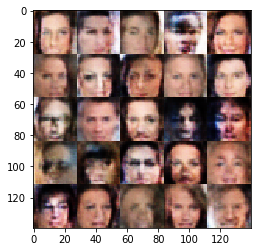

Epoch 1/1... Batch 1810... Discriminator Loss: 1.1462... Generator Loss: 0.9775
Epoch 1/1... Batch 1820... Discriminator Loss: 1.0414... Generator Loss: 1.0693
Epoch 1/1... Batch 1830... Discriminator Loss: 1.0224... Generator Loss: 0.9871
Epoch 1/1... Batch 1840... Discriminator Loss: 0.9672... Generator Loss: 1.2341
Epoch 1/1... Batch 1850... Discriminator Loss: 1.1114... Generator Loss: 0.9439
Epoch 1/1... Batch 1860... Discriminator Loss: 1.1783... Generator Loss: 0.8768
Epoch 1/1... Batch 1870... Discriminator Loss: 1.1597... Generator Loss: 0.7979
Epoch 1/1... Batch 1880... Discriminator Loss: 1.1327... Generator Loss: 0.8390
Epoch 1/1... Batch 1890... Discriminator Loss: 1.1314... Generator Loss: 1.1089
Epoch 1/1... Batch 1900... Discriminator Loss: 1.1302... Generator Loss: 1.0506


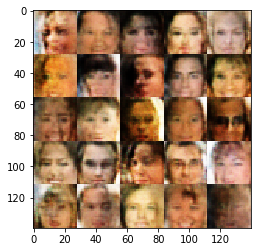

Epoch 1/1... Batch 1910... Discriminator Loss: 1.1714... Generator Loss: 0.8920
Epoch 1/1... Batch 1920... Discriminator Loss: 1.1475... Generator Loss: 1.0797
Epoch 1/1... Batch 1930... Discriminator Loss: 1.1469... Generator Loss: 0.8405
Epoch 1/1... Batch 1940... Discriminator Loss: 1.1230... Generator Loss: 0.8730
Epoch 1/1... Batch 1950... Discriminator Loss: 1.1261... Generator Loss: 0.8464
Epoch 1/1... Batch 1960... Discriminator Loss: 1.1412... Generator Loss: 0.8917
Epoch 1/1... Batch 1970... Discriminator Loss: 1.1302... Generator Loss: 1.0814
Epoch 1/1... Batch 1980... Discriminator Loss: 1.1923... Generator Loss: 0.7183
Epoch 1/1... Batch 1990... Discriminator Loss: 1.0642... Generator Loss: 0.9975
Epoch 1/1... Batch 2000... Discriminator Loss: 1.1585... Generator Loss: 0.8099


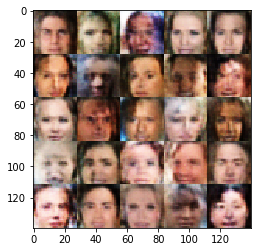

Epoch 1/1... Batch 2010... Discriminator Loss: 1.0449... Generator Loss: 1.2263
Epoch 1/1... Batch 2020... Discriminator Loss: 1.2332... Generator Loss: 0.7296
Epoch 1/1... Batch 2030... Discriminator Loss: 1.0110... Generator Loss: 0.9876
Epoch 1/1... Batch 2040... Discriminator Loss: 1.1568... Generator Loss: 0.9978
Epoch 1/1... Batch 2050... Discriminator Loss: 1.3130... Generator Loss: 0.7722
Epoch 1/1... Batch 2060... Discriminator Loss: 0.9549... Generator Loss: 1.2417
Epoch 1/1... Batch 2070... Discriminator Loss: 1.1588... Generator Loss: 0.8536
Epoch 1/1... Batch 2080... Discriminator Loss: 1.2132... Generator Loss: 0.7736
Epoch 1/1... Batch 2090... Discriminator Loss: 1.0996... Generator Loss: 0.9697
Epoch 1/1... Batch 2100... Discriminator Loss: 1.1945... Generator Loss: 0.7780


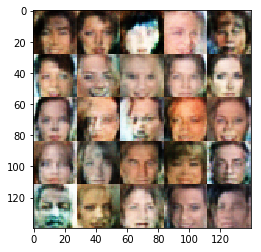

Epoch 1/1... Batch 2110... Discriminator Loss: 1.1554... Generator Loss: 0.8280
Epoch 1/1... Batch 2120... Discriminator Loss: 0.9864... Generator Loss: 1.0805
Epoch 1/1... Batch 2130... Discriminator Loss: 1.1717... Generator Loss: 1.2229
Epoch 1/1... Batch 2140... Discriminator Loss: 1.1217... Generator Loss: 1.0839
Epoch 1/1... Batch 2150... Discriminator Loss: 1.0454... Generator Loss: 1.0188
Epoch 1/1... Batch 2160... Discriminator Loss: 1.3139... Generator Loss: 0.5756
Epoch 1/1... Batch 2170... Discriminator Loss: 1.0554... Generator Loss: 0.8033
Epoch 1/1... Batch 2180... Discriminator Loss: 1.1851... Generator Loss: 0.9343
Epoch 1/1... Batch 2190... Discriminator Loss: 1.2179... Generator Loss: 0.7460
Epoch 1/1... Batch 2200... Discriminator Loss: 1.0930... Generator Loss: 0.9357


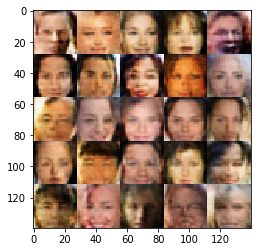

Epoch 1/1... Batch 2210... Discriminator Loss: 1.3900... Generator Loss: 0.6138
Epoch 1/1... Batch 2220... Discriminator Loss: 1.3137... Generator Loss: 0.8506
Epoch 1/1... Batch 2230... Discriminator Loss: 1.2556... Generator Loss: 0.8079
Epoch 1/1... Batch 2240... Discriminator Loss: 1.0333... Generator Loss: 1.0525
Epoch 1/1... Batch 2250... Discriminator Loss: 1.1803... Generator Loss: 0.8121
Epoch 1/1... Batch 2260... Discriminator Loss: 1.0608... Generator Loss: 0.9775
Epoch 1/1... Batch 2270... Discriminator Loss: 1.2083... Generator Loss: 0.8763
Epoch 1/1... Batch 2280... Discriminator Loss: 1.0548... Generator Loss: 1.0710
Epoch 1/1... Batch 2290... Discriminator Loss: 1.2023... Generator Loss: 0.9424
Epoch 1/1... Batch 2300... Discriminator Loss: 1.1151... Generator Loss: 0.9437


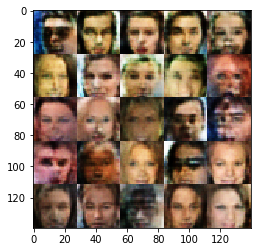

Epoch 1/1... Batch 2310... Discriminator Loss: 1.0757... Generator Loss: 1.2173
Epoch 1/1... Batch 2320... Discriminator Loss: 1.1852... Generator Loss: 0.9024
Epoch 1/1... Batch 2330... Discriminator Loss: 1.1643... Generator Loss: 0.8845
Epoch 1/1... Batch 2340... Discriminator Loss: 1.2294... Generator Loss: 0.7330
Epoch 1/1... Batch 2350... Discriminator Loss: 1.0873... Generator Loss: 1.1320
Epoch 1/1... Batch 2360... Discriminator Loss: 1.1944... Generator Loss: 0.8559
Epoch 1/1... Batch 2370... Discriminator Loss: 0.9828... Generator Loss: 1.1771
Epoch 1/1... Batch 2380... Discriminator Loss: 1.0552... Generator Loss: 0.9555
Epoch 1/1... Batch 2390... Discriminator Loss: 1.0168... Generator Loss: 1.0560
Epoch 1/1... Batch 2400... Discriminator Loss: 1.0271... Generator Loss: 1.2852


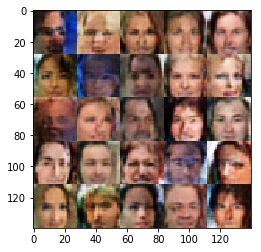

Epoch 1/1... Batch 2410... Discriminator Loss: 1.0961... Generator Loss: 1.0823
Epoch 1/1... Batch 2420... Discriminator Loss: 1.0483... Generator Loss: 1.1644
Epoch 1/1... Batch 2430... Discriminator Loss: 1.2692... Generator Loss: 0.8990
Epoch 1/1... Batch 2440... Discriminator Loss: 1.3304... Generator Loss: 0.7208
Epoch 1/1... Batch 2450... Discriminator Loss: 1.1954... Generator Loss: 0.7381
Epoch 1/1... Batch 2460... Discriminator Loss: 1.1099... Generator Loss: 1.0189
Epoch 1/1... Batch 2470... Discriminator Loss: 1.6051... Generator Loss: 0.5764
Epoch 1/1... Batch 2480... Discriminator Loss: 1.1435... Generator Loss: 1.0733
Epoch 1/1... Batch 2490... Discriminator Loss: 1.3224... Generator Loss: 1.1445
Epoch 1/1... Batch 2500... Discriminator Loss: 1.0753... Generator Loss: 1.0353


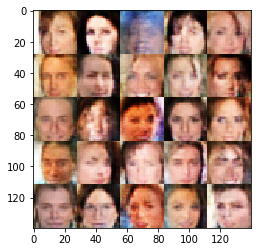

Epoch 1/1... Batch 2510... Discriminator Loss: 1.1953... Generator Loss: 0.7777
Epoch 1/1... Batch 2520... Discriminator Loss: 1.2968... Generator Loss: 0.7919
Epoch 1/1... Batch 2530... Discriminator Loss: 1.2868... Generator Loss: 0.8835
Epoch 1/1... Batch 2540... Discriminator Loss: 1.2056... Generator Loss: 0.7766
Epoch 1/1... Batch 2550... Discriminator Loss: 1.2582... Generator Loss: 0.8474
Epoch 1/1... Batch 2560... Discriminator Loss: 1.2029... Generator Loss: 0.7646
Epoch 1/1... Batch 2570... Discriminator Loss: 1.2497... Generator Loss: 0.6563
Epoch 1/1... Batch 2580... Discriminator Loss: 1.4584... Generator Loss: 0.7884
Epoch 1/1... Batch 2590... Discriminator Loss: 1.1706... Generator Loss: 0.7710
Epoch 1/1... Batch 2600... Discriminator Loss: 0.9507... Generator Loss: 1.0831


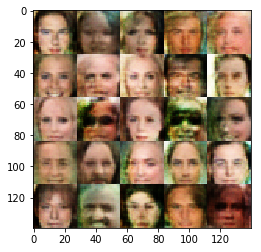

Epoch 1/1... Batch 2610... Discriminator Loss: 1.0444... Generator Loss: 1.0293
Epoch 1/1... Batch 2620... Discriminator Loss: 1.2558... Generator Loss: 0.7579
Epoch 1/1... Batch 2630... Discriminator Loss: 1.4064... Generator Loss: 0.5288
Epoch 1/1... Batch 2640... Discriminator Loss: 1.1474... Generator Loss: 1.0365
Epoch 1/1... Batch 2650... Discriminator Loss: 1.1618... Generator Loss: 1.2616
Epoch 1/1... Batch 2660... Discriminator Loss: 1.1443... Generator Loss: 0.8174
Epoch 1/1... Batch 2670... Discriminator Loss: 1.1983... Generator Loss: 0.9303
Epoch 1/1... Batch 2680... Discriminator Loss: 1.2531... Generator Loss: 0.6246
Epoch 1/1... Batch 2690... Discriminator Loss: 1.1254... Generator Loss: 0.9238
Epoch 1/1... Batch 2700... Discriminator Loss: 1.3196... Generator Loss: 0.7747


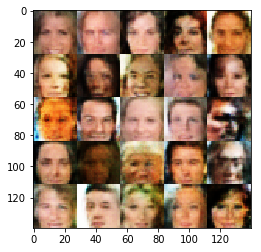

Epoch 1/1... Batch 2710... Discriminator Loss: 1.1559... Generator Loss: 0.8121
Epoch 1/1... Batch 2720... Discriminator Loss: 1.3149... Generator Loss: 0.5736
Epoch 1/1... Batch 2730... Discriminator Loss: 0.9301... Generator Loss: 1.2636
Epoch 1/1... Batch 2740... Discriminator Loss: 1.2197... Generator Loss: 0.6862
Epoch 1/1... Batch 2750... Discriminator Loss: 1.3032... Generator Loss: 0.7418
Epoch 1/1... Batch 2760... Discriminator Loss: 1.1930... Generator Loss: 0.7115
Epoch 1/1... Batch 2770... Discriminator Loss: 1.5239... Generator Loss: 0.4786
Epoch 1/1... Batch 2780... Discriminator Loss: 1.2893... Generator Loss: 0.6336
Epoch 1/1... Batch 2790... Discriminator Loss: 1.1611... Generator Loss: 0.8522
Epoch 1/1... Batch 2800... Discriminator Loss: 1.1912... Generator Loss: 0.7390


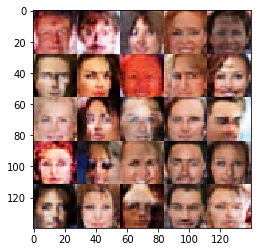

Epoch 1/1... Batch 2810... Discriminator Loss: 1.0284... Generator Loss: 0.9153
Epoch 1/1... Batch 2820... Discriminator Loss: 0.9129... Generator Loss: 1.1997
Epoch 1/1... Batch 2830... Discriminator Loss: 1.1398... Generator Loss: 1.4644
Epoch 1/1... Batch 2840... Discriminator Loss: 1.2252... Generator Loss: 0.8400
Epoch 1/1... Batch 2850... Discriminator Loss: 1.3043... Generator Loss: 0.6667
Epoch 1/1... Batch 2860... Discriminator Loss: 1.0580... Generator Loss: 1.0361
Epoch 1/1... Batch 2870... Discriminator Loss: 1.1653... Generator Loss: 0.8745
Epoch 1/1... Batch 2880... Discriminator Loss: 1.3336... Generator Loss: 0.7354
Epoch 1/1... Batch 2890... Discriminator Loss: 1.1351... Generator Loss: 0.9243
Epoch 1/1... Batch 2900... Discriminator Loss: 1.1001... Generator Loss: 1.1922


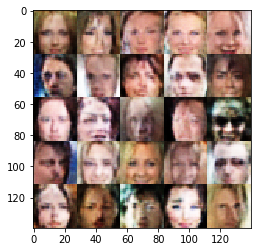

Epoch 1/1... Batch 2910... Discriminator Loss: 1.1030... Generator Loss: 0.8488
Epoch 1/1... Batch 2920... Discriminator Loss: 1.0176... Generator Loss: 0.9328
Epoch 1/1... Batch 2930... Discriminator Loss: 1.2446... Generator Loss: 0.7509
Epoch 1/1... Batch 2940... Discriminator Loss: 1.1834... Generator Loss: 0.8722
Epoch 1/1... Batch 2950... Discriminator Loss: 1.2094... Generator Loss: 0.8072
Epoch 1/1... Batch 2960... Discriminator Loss: 1.1583... Generator Loss: 0.9290
Epoch 1/1... Batch 2970... Discriminator Loss: 1.0741... Generator Loss: 1.2530
Epoch 1/1... Batch 2980... Discriminator Loss: 1.1823... Generator Loss: 1.3273
Epoch 1/1... Batch 2990... Discriminator Loss: 1.1311... Generator Loss: 0.7834
Epoch 1/1... Batch 3000... Discriminator Loss: 1.0570... Generator Loss: 0.9991


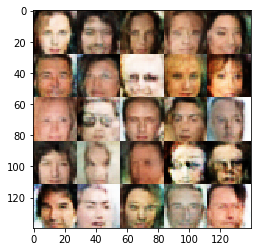

Epoch 1/1... Batch 3010... Discriminator Loss: 1.1497... Generator Loss: 0.7354
Epoch 1/1... Batch 3020... Discriminator Loss: 1.1475... Generator Loss: 0.7525
Epoch 1/1... Batch 3030... Discriminator Loss: 1.0130... Generator Loss: 0.9984
Epoch 1/1... Batch 3040... Discriminator Loss: 0.9031... Generator Loss: 1.3053
Epoch 1/1... Batch 3050... Discriminator Loss: 1.2745... Generator Loss: 0.7592
Epoch 1/1... Batch 3060... Discriminator Loss: 1.1733... Generator Loss: 0.9156
Epoch 1/1... Batch 3070... Discriminator Loss: 1.2175... Generator Loss: 0.6805
Epoch 1/1... Batch 3080... Discriminator Loss: 1.1298... Generator Loss: 0.8400
Epoch 1/1... Batch 3090... Discriminator Loss: 1.1089... Generator Loss: 1.0312
Epoch 1/1... Batch 3100... Discriminator Loss: 1.2108... Generator Loss: 0.8414


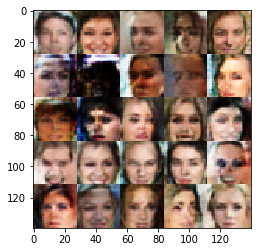

Epoch 1/1... Batch 3110... Discriminator Loss: 1.4065... Generator Loss: 0.5253
Epoch 1/1... Batch 3120... Discriminator Loss: 1.0924... Generator Loss: 1.1520
Epoch 1/1... Batch 3130... Discriminator Loss: 1.2870... Generator Loss: 0.7654
Epoch 1/1... Batch 3140... Discriminator Loss: 1.2060... Generator Loss: 0.9286
Epoch 1/1... Batch 3150... Discriminator Loss: 1.1768... Generator Loss: 0.9597
Epoch 1/1... Batch 3160... Discriminator Loss: 1.2231... Generator Loss: 0.7065


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.